# Importing Libraries

In [1]:
import numpy as np
import scipy as sp

# Visualization libraries
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style

import collections
import queue
import scipy.io as spio

from numpy import linalg as LA
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import MinMaxScaler
import sys

In [2]:
# Loading dataset
df=pd.read_csv('cancer.csv', delimiter=',')

In [3]:
# Scaling
scaler = MinMaxScaler()
df2=df.copy()
df2=df2.drop(['id', 'diagnosis', 'Unnamed: 32'], axis=1)
df2 = pd.DataFrame(scaler.fit_transform(df2), columns=df2.columns)

In [4]:
datapoints = df2.values
m, f = datapoints.shape

# DB-SCAN Clustering

In [5]:
# Defining  label for different point groups

NOISE = 0
UNASSIGNED = 0
core=-1
border=-2

In [6]:
# function to find all points in neighbourhood radius
def neighbor_points(data, pointId, radius):
    points = []
    for i in range(len(data)):
        #Euclidian distance using L2 Norm
        if np.linalg.norm(data[i] - data[pointId]) <= radius:
            points.append(i)
    return points

In [7]:
# DB Scan algorithom
def dbscan(data, Eps, MinPt):
    #initiliaze all point labels to unassigned
    pointlabel  = [UNASSIGNED] * len(data)
    pointcount = []
    #initiliaze list for core/noncore points
    corepoint=[]
    noncore=[]
    
    #Find all neighbor for all points
    for i in range(len(data)):
        pointcount.append(neighbor_points(datapoints, i ,Eps))
    
    #Find all core point, edgepoint and noise
    for i in range(len(pointcount)):
        if (len(pointcount[i])>=MinPt):
            pointlabel[i]=core
            corepoint.append(i)
        else:
            noncore.append(i)

    for i in noncore:
        for j in pointcount[i]:
            if j in corepoint:
                pointlabel[i]=border
                break
            
    #start assigning point to cluster
    cl = 1
    #Using a Queue to put all neighbour core point in queue and find neigbour's neigbour
    for i in range(len(pointlabel)):
        q = queue.Queue()
        if (pointlabel[i] == core):
            pointlabel[i] = cl
            for x in pointcount[i]:
                if(pointlabel[x]==core):
                    q.put(x)
                    pointlabel[x]=cl
                elif(pointlabel[x]==border):
                    pointlabel[x]=cl
            #Stop when all points in Queue has been checked   
            while not q.empty():
                neighbors = pointcount[q.get()]
                for y in neighbors:
                    if (pointlabel[y]==core):
                        pointlabel[y]=cl
                        q.put(y)
                    if (pointlabel[y]==border):
                        pointlabel[y]=cl            
            cl=cl+1 # move to next cluster
           
    return pointlabel,cl


In [11]:
#Plot final result
def plotRes(data, clusterRes, clusterNum):
    style.use('fivethirtyeight')
    plt.figure(figsize = (10, 6))  
    plt.xlabel("radius_mean") 
    plt.ylabel("texture_mean") 
    area = (20) ** 2
    nPoints = len(data)
    scatterColors = ['black', 'green', 'brown', 'blue', 'purple', 'orange', 'yellow']
    for i in range(clusterNum):
        if (i==0):
            #Plot all noise point as blue
            color='red'
        else:
            color = scatterColors[i % len(scatterColors)]
        x1 = [];  y1 = []
        for j in range(nPoints):
            if clusterRes[j] == i:
                x1.append(data[j, 0])
                y1.append(data[j, 1])
        plt.title('DB-SCAN')
        plt.scatter(x1, y1, c=color, alpha=0.8)
        


In [12]:
#Set EPS and Minpoint
epss = [0.2, 0.5, 0.2]
minptss = [6, 6, 3]


Set Eps = 0.2, Minpoints = 6


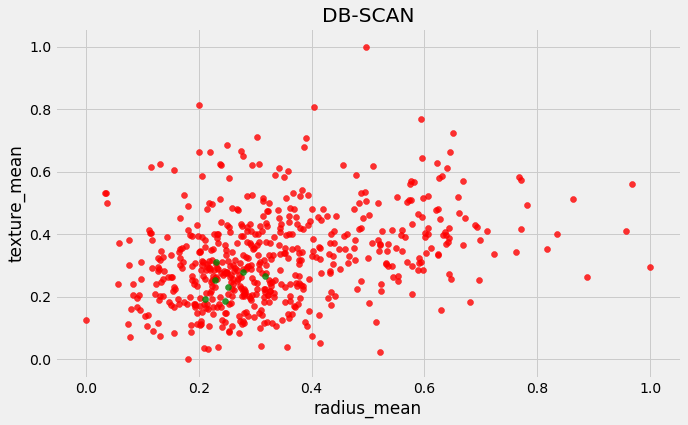

Number of clusters found: 1
Counter({0: 562, 1: 7})
Number of outliers found: 562

Set Eps = 0.5, Minpoints = 6


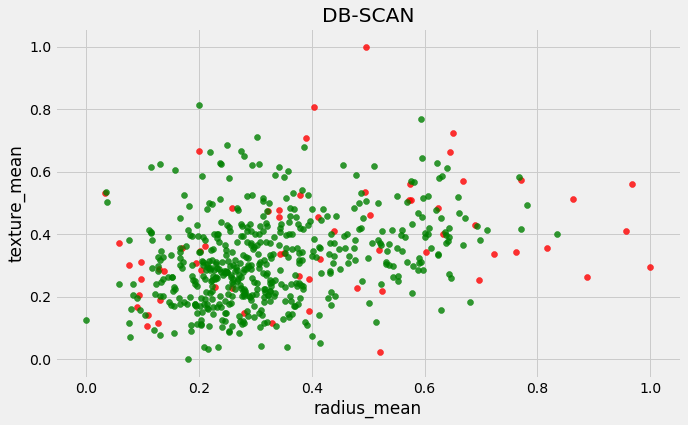

Number of clusters found: 1
Counter({1: 504, 0: 65})
Number of outliers found: 65

Set Eps = 0.2, Minpoints = 3


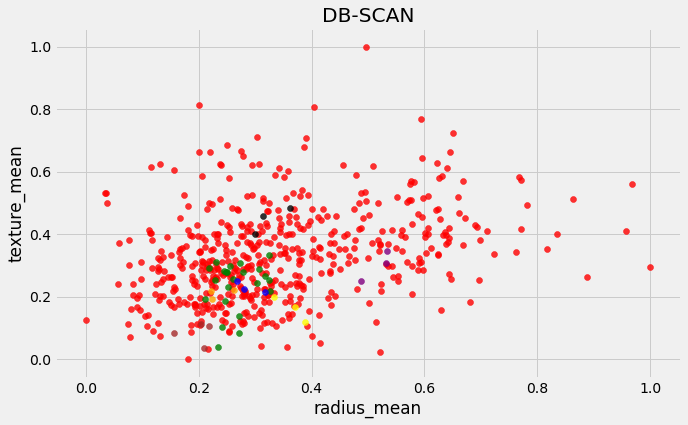

Number of clusters found: 7
Counter({0: 527, 1: 23, 2: 4, 4: 3, 7: 3, 3: 3, 5: 3, 6: 3})
Number of outliers found: 527



In [13]:
# Find All cluster, outliers in different setting and print results

for i in range(len(epss)):
    eps=epss[i]
    minpts=minptss[i]
    print('Set Eps = ' +str(eps)+ ', Minpoints = '+str(minpts))
    pointlabel, cl = dbscan(datapoints, eps, minpts)
    plotRes(datapoints, pointlabel, cl)
    plt.show()
    print('Number of clusters found: ' + str(cl-1))
    counter=collections.Counter(pointlabel)
    print(counter)
    outliers  = pointlabel.count(0)
    print('Number of outliers found: '+str(outliers) +'\n')
